# Emotion-Recognition Kaggle Model V5

I will try a new approach this time, I will add a new set, called test set in order to plot predictions with a Confusion Matrix. I will start simple again and try to go fast for this new initial iterations.

In [1]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from sklearn.metrics import confusion_matrix
import random
import glob
import itertools
import os
import shutil
import seedir as sd
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# Classses Distribution
print("Dataset Classes Distribution")

# Path to dataset
dataset_path = '../datasets/kaggle_dataset_train/'

# Let's display and count the files in the Kaggle training dataset
sd.seedir(dataset_path, style='emoji', itemlimit=10, depthlimit=1, beyond='content')

# Find number of images for each class
classes = []
values = []
for emotion in os.listdir(dataset_path):
    classes.append(emotion)
    values.append(len(os.listdir(dataset_path+emotion)))

# Chart visualization of the classes
fig = pgo.Figure(data=[pgo.Pie(labels=classes, values=values, hole=.4)])
fig.show()

Dataset Classes Distribution
📁 /
├─📁 angry/
│ └─0 folder(s), 3595 file(s)
├─📁 disgust/
│ └─0 folder(s), 393 file(s)
├─📁 fear/
│ └─0 folder(s), 3688 file(s)
├─📁 happy/
│ └─0 folder(s), 6493 file(s)
├─📁 neutral/
│ └─0 folder(s), 4469 file(s)
├─📁 sad/
│ └─0 folder(s), 4347 file(s)
└─📁 surprise/
  └─0 folder(s), 2854 file(s)


In [3]:
# I create a different folder for the validation set
os.chdir('../datasets/')
if os.path.isdir('kaggle_dataset_validate/') is False:
    os.makedirs('kaggle_dataset_validate/angry')
    os.makedirs('kaggle_dataset_validate/disgust')
    os.makedirs('kaggle_dataset_validate/fear')
    os.makedirs('kaggle_dataset_validate/happy')
    os.makedirs('kaggle_dataset_validate/neutral')
    os.makedirs('kaggle_dataset_validate/sad')
    os.makedirs('kaggle_dataset_validate/surprise')

    # Now I move 10% of random images from each train class to the proper validation set
    for i in random.sample(glob.glob('kaggle_dataset_train/angry/*'), 399):
        shutil.move(i, 'kaggle_dataset_validate/angry')        
    for i in random.sample(glob.glob('kaggle_dataset_train/disgust/*'), 43):
        shutil.move(i, 'kaggle_dataset_validate/disgust')
    for i in random.sample(glob.glob('kaggle_dataset_train/fear/*'), 409):
        shutil.move(i, 'kaggle_dataset_validate/fear')
    for i in random.sample(glob.glob('kaggle_dataset_train/happy/*'), 721):
        shutil.move(i, 'kaggle_dataset_validate/happy')
    for i in random.sample(glob.glob('kaggle_dataset_train/neutral/*'), 496):
        shutil.move(i, 'kaggle_dataset_validate/neutral')
    for i in random.sample(glob.glob('kaggle_dataset_train/sad/*'), 483):
        shutil.move(i, 'kaggle_dataset_validate/sad')
    for i in random.sample(glob.glob('kaggle_dataset_train/surprise/*'), 317):
        shutil.move(i, 'kaggle_dataset_validate/surprise')


os.chdir('../notebooks')

In [4]:
# Process the data
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Define sets
# Since the tesing set has more data than the created validate, we will use test as validate and validate as test
training_path = '../datasets/kaggle_dataset_train/'
valididation_path = '../datasets/kaggle_dataset_test/'
testing_path = '../datasets/kaggle_dataset_validate/'

Num GPUs Available:  1


In [5]:
# Now we use Keras's ImageDataGenerator class to create batches of data from the training, validation and testing sets
train_batches = ImageDataGenerator().flow_from_directory(directory=training_path, target_size=(48,48), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], color_mode="grayscale", batch_size=32)
valid_batches = ImageDataGenerator().flow_from_directory(directory=valididation_path, target_size=(48,48), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], color_mode="grayscale", batch_size=32)
test_batches = ImageDataGenerator().flow_from_directory(directory=testing_path, target_size=(48,48), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], color_mode="grayscale", batch_size=32, shuffle=False)

Found 25839 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 2867 images belonging to 7 classes.


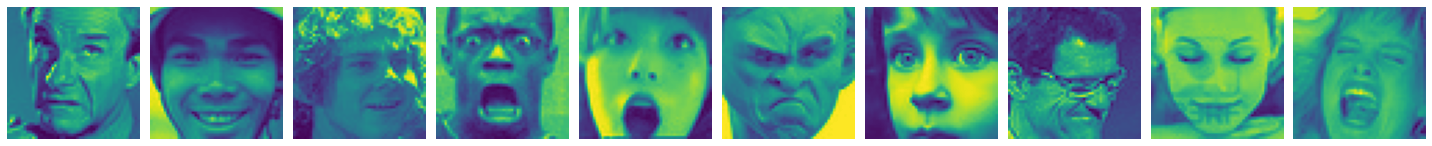

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


In [6]:
imgs, labels = next(train_batches)

# Plotting function obtained from TensorFlow's documentation to plot the processed images within our Jupyter notebook.
# The classes are represented with the one-hot encoding , for example 'angry' is [1. 0. 0. 0. 0. 0. 0.]

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

In [7]:
# For now I will simplify the model as much as possible since the older models I created gave problems such as overfitting and sometimes underfitting. So let me start over with a very basic model.

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(48,48,1)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=7, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 64519     
Total params: 83,335
Trainable params: 83,335
Non-trainable params: 0
____________________________________________________

The model itself is very simple, we have an input layer that takes images images that are 48 by 48 with only 1 channel (grayscale), the we have 2 hidden layers each followed by maxpooling in order to reduce the dimension. We also enable zero-padding by specifying padding = 'same'.
The output layer has 7 outputs each for each emotion class. Again, very simple, then later I will make it more complex or maybe use as base another trained model.

In [11]:
# Now that the model is built, we compile the model using the Adam optimizer with a learning rate of 0.0001, a loss of categorical_cross_entropy, and we'll look at accuracy as our performance metric.

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Now I will train the model using 
model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=40,
    verbose=2
)

Epoch 1/40
808/808 - 20s - loss: 3.4710 - accuracy: 0.2549 - val_loss: 2.2601 - val_accuracy: 0.3033
Epoch 2/40
808/808 - 6s - loss: 1.9571 - accuracy: 0.3338 - val_loss: 1.8172 - val_accuracy: 0.3484
Epoch 3/40
808/808 - 6s - loss: 1.6466 - accuracy: 0.3909 - val_loss: 1.6630 - val_accuracy: 0.3870
Epoch 4/40
808/808 - 6s - loss: 1.5043 - accuracy: 0.4345 - val_loss: 1.5865 - val_accuracy: 0.4065
Epoch 5/40
808/808 - 6s - loss: 1.4002 - accuracy: 0.4718 - val_loss: 1.5457 - val_accuracy: 0.4322
Epoch 6/40
808/808 - 6s - loss: 1.3184 - accuracy: 0.5019 - val_loss: 1.5028 - val_accuracy: 0.4464
Epoch 7/40
808/808 - 6s - loss: 1.2442 - accuracy: 0.5305 - val_loss: 1.4969 - val_accuracy: 0.4510
Epoch 8/40
808/808 - 6s - loss: 1.1814 - accuracy: 0.5605 - val_loss: 1.5084 - val_accuracy: 0.4557
Epoch 9/40
808/808 - 6s - loss: 1.1264 - accuracy: 0.5828 - val_loss: 1.5110 - val_accuracy: 0.4576
Epoch 10/40
808/808 - 6s - loss: 1.0658 - accuracy: 0.6063 - val_loss: 1.5037 - val_accuracy: 0.457

From this output, we can see the performance of this simple model on the training set is good, with accuracy reaching `93%` and loss nearing `0.2`, however, by comparing these results to the validation metrics, we can see that our model is vastly `overfitting` to the training data.

We could keep training the model for more epochs but it won't change much. The model performs good on the training set but it's not able to generalize on the validation set. Let's try to understand more in which class had problems.

Confusion matrix, without normalization
[[122   3  70  47  79  60  18]
 [  7  15   4   5   3   7   2]
 [ 45   2 144  39  66  60  53]
 [ 45   2  64 434  66  83  27]
 [ 48   1  57  59 215  88  28]
 [ 66   1  85  48 103 158  22]
 [  9   1  38  17  23  16 212]]


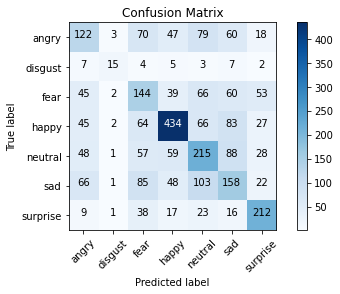

In [21]:
# Plotting Predictions With A Confusion Matrix
# To get a better visualization of these results, we'll plot them in a confusion matrix

test_imgs, test_labels = next(test_batches)
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

We can see that the model correctly predicted that an image contained 'angry' emotion 122 times when it was actually 'angry', but incorrectly predicted 7 times to be 'disgust' while it was indeed still 'angry'. We can see from the matrix that the for the 'angry' images it predicted the corret label 122 but failed 220 times. That's a very bad performance.

In [22]:
# I will save anyways the model for the archive
model.save("kaggle_model_v5.h5")